# Bank Customer Churn Prediction - Data Preparation and Modeling

This notebook focuses on preparing the data for modeling and building predictive models to identify customers likely to churn. We will:

1. Load and prepare the data
2. Engineer features 
3. Split the data into training and testing sets
4. Build and evaluate multiple models
5. Interpret the results
6. Draw conclusions and make recommendations

Let's begin by loading our dataset and the necessary libraries.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import shap
import warnings

# Configure visualizations
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
warnings.filterwarnings('ignore')

Loading data

In [2]:
# Load the dataset
df = pd.read_csv('../Bank Customer Churn Prediction.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

# Check data types and missing values
print("\nData Types and Missing Values:")
display(df.info())

# Basic statistics
print("\nSummary Statistics:")
display(df.describe())

# Target variable distribution
print("\nChurn Distribution:")
print(df['churn'].value_counts())
print(df['churn'].value_counts(normalize=True) * 100)

Dataset Shape: (10000, 12)

First 5 rows:


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0



Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


None


Summary Statistics:


,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000



Churn Distribution:
churn
0    7963
1    2037
Name: count, dtype: int64
churn
0    79.63
1    20.37
Name: proportion, dtype: float64


## Data Preparation

Now we'll prepare our data for modeling by:
1. Creating additional engineered features
2. Handling categorical variables
3. Scaling numerical features
4. Splitting the dataset into training and testing sets

These steps are crucial for building effective predictive models.

Feature engineering

In [3]:
# Create a copy of the dataframe for feature engineering
df_model = df.copy()

# Drop customer_id as it's not useful for prediction
df_model.drop('customer_id', axis=1, inplace=True)

# Create additional features based on insights from EDA
# Balance-to-Income ratio
df_model['balance_to_income_ratio'] = df_model['balance'] / df_model['estimated_salary']

# Balance per Product
df_model['balance_per_product'] = df_model['balance'] / df_model['products_number']

# Products to Age ratio (products per decade of age)
df_model['products_per_decade'] = df_model['products_number'] / (df_model['age'] / 10)

# Customer Engagement Score 
df_model['engagement_score'] = (df_model['active_member'] * 3) + (df_model['credit_card'] * 2) + \
                              (df_model['tenure'] / df_model['tenure'].max() * 5)

# Handle infinite values and NaNs in the numeric columns
numeric_cols = df_model.select_dtypes(include=['float64', 'int64']).columns
df_model[numeric_cols] = df_model[numeric_cols].replace([np.inf, -np.inf], np.nan)
df_model[numeric_cols] = df_model[numeric_cols].fillna(0)

# Display the new dataframe with engineered features
print("Dataframe with new features:")
print(df_model.shape)
display(df_model.head())

Dataframe with new features:
(10000, 15)


,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn,balance_to_income_ratio,balance_per_product,products_per_decade,engagement_score
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,0.000000,0.000000,0.238095,6.0
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,0.744677,83807.860000,0.243902,3.5
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1.401375,53220.266667,0.714286,6.0
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0.000000,0.000000,0.512821,0.5
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,1.587055,125510.820000,0.232558,6.0


Preparation for modeling

In [4]:
# Define features and target
X = df_model.drop('churn', axis=1)
y = df_model['churn']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")

# Create preprocessing pipelines
# Numerical pipeline: impute missing values and scale
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: impute missing values and one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Check the class balance
print("\nClass balance in training set:")
print(y_train.value_counts(normalize=True) * 100)

Categorical columns: ['country', 'gender']
Numerical columns: ['credit_score', 'age', 'tenure', 'balance', 'products_number', 'credit_card', 'active_member', 'estimated_salary', 'balance_to_income_ratio', 'balance_per_product', 'products_per_decade', 'engagement_score']

Training set shape: (8000, 14), (8000,)
Testing set shape: (2000, 14), (2000,)

Class balance in training set:
churn
0    79.625
1    20.375
Name: proportion, dtype: float64


## Modeling

We'll build and evaluate multiple models:
1. Logistic Regression (baseline)
2. Random Forest
3. Gradient Boosting
4. XGBoost

For each model, we'll evaluate performance using:
- Accuracy, Precision, Recall, F1-Score
- ROC AUC and Confusion Matrix
- Cross-validation for robustness

Baseline model (Logistic Regression)

Logistic Regression Model Evaluation:
Accuracy: 0.7025
Precision: 0.3792
Recall: 0.7248
F1 Score: 0.4979
ROC AUC: 0.7807


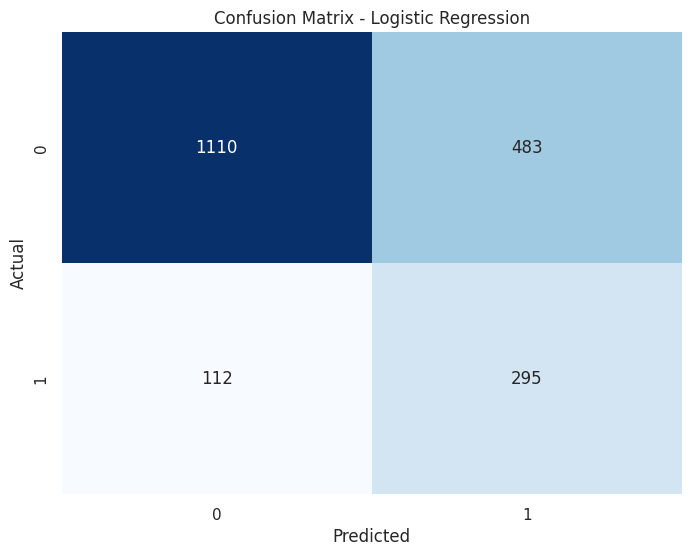


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      1593
           1       0.38      0.72      0.50       407

    accuracy                           0.70      2000
   macro avg       0.64      0.71      0.64      2000
weighted avg       0.80      0.70      0.73      2000


Cross-validation ROC AUC scores: [0.78242007 0.76982646 0.77780708 0.77569249 0.74864849]
Mean CV Score: 0.7709 ± 0.0118


In [5]:
# Create a pipeline for Logistic Regression
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])

# Train the model
log_reg_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_log_reg = log_reg_pipeline.predict(X_test)
y_prob_log_reg = log_reg_pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Logistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_log_reg):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_log_reg):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_log_reg):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_log_reg):.4f}")

# Display confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_log_reg)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log_reg))

# Perform cross-validation
cv_scores = cross_val_score(log_reg_pipeline, X, y, cv=5, scoring='roc_auc')
print(f"\nCross-validation ROC AUC scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Random Forest Model

Random Forest Model Evaluation:
Accuracy: 0.8635
Precision: 0.7939
Recall: 0.4447
F1 Score: 0.5701
ROC AUC: 0.8520


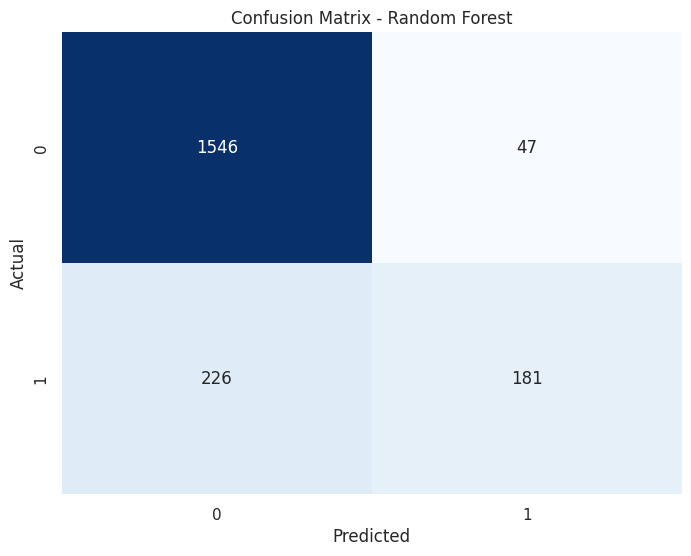


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1593
           1       0.79      0.44      0.57       407

    accuracy                           0.86      2000
   macro avg       0.83      0.71      0.74      2000
weighted avg       0.86      0.86      0.85      2000


Cross-validation ROC AUC scores: [0.84183633 0.86185292 0.85245029 0.85559751 0.84963392]
Mean CV Score: 0.8523 ± 0.0066


In [6]:
# Create a pipeline for Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

# Train the model
rf_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_pipeline.predict(X_test)
y_prob_rf = rf_pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Random Forest Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_rf):.4f}")

# Display confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

# Perform cross-validation
cv_scores = cross_val_score(rf_pipeline, X, y, cv=5, scoring='roc_auc')
print(f"\nCross-validation ROC AUC scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

XGBoost Model

XGBoost Model Evaluation:
Accuracy: 0.8265
Precision: 0.5664
Recall: 0.6290
F1 Score: 0.5960
ROC AUC: 0.8455


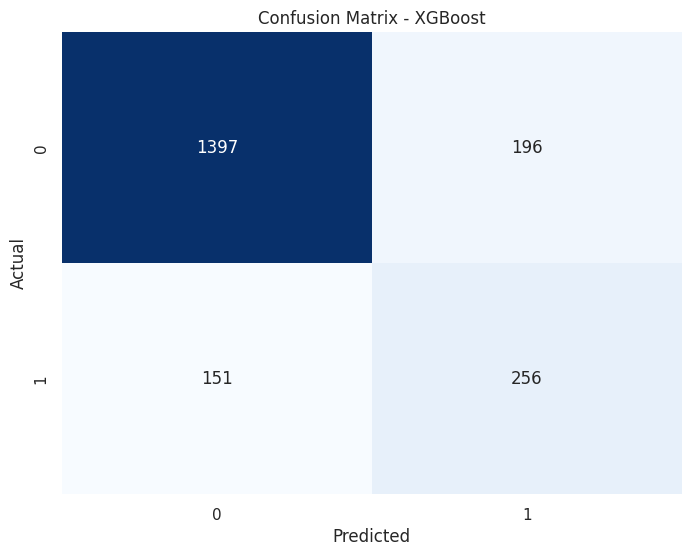


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1593
           1       0.57      0.63      0.60       407

    accuracy                           0.83      2000
   macro avg       0.73      0.75      0.74      2000
weighted avg       0.83      0.83      0.83      2000


Cross-validation ROC AUC scores: [0.83267286 0.85422363 0.83873242 0.84467364 0.83466826]
Mean CV Score: 0.8410 ± 0.0078


In [7]:
# Create a pipeline for XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42, scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])))
])

# Train the model
xgb_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_pipeline.predict(X_test)
y_prob_xgb = xgb_pipeline.predict_proba(X_test)[:, 1]

# Evaluate the model
print("XGBoost Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_xgb):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_xgb):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_xgb):.4f}")

# Display confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

# Perform cross-validation
cv_scores = cross_val_score(xgb_pipeline, X, y, cv=5, scoring='roc_auc')
print(f"\nCross-validation ROC AUC scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

Comparison of Models

Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Logistic Regression,0.7025,0.379177,0.724816,0.497890,0.780741
1,Random Forest,0.8635,0.793860,0.444717,0.570079,0.851995
2,XGBoost,0.8265,0.566372,0.628993,0.596042,0.845505


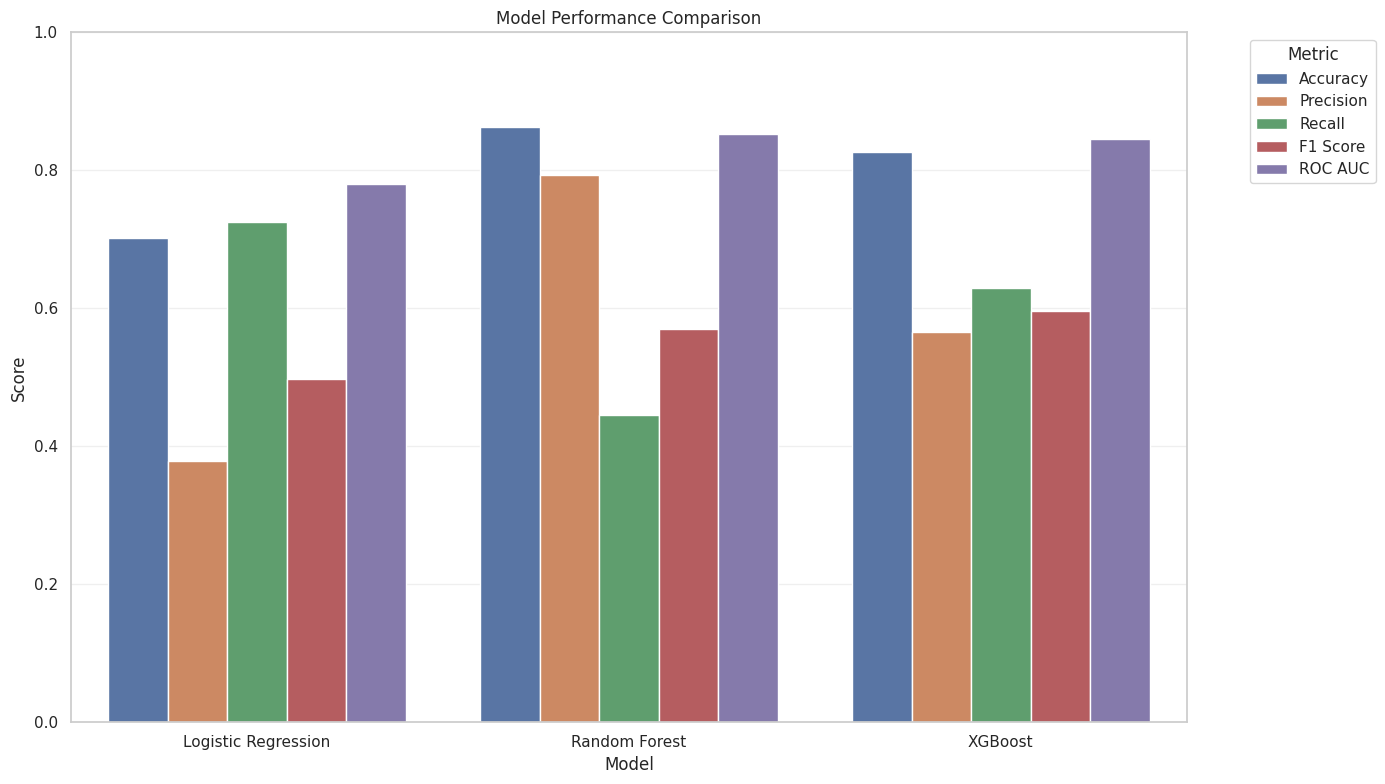

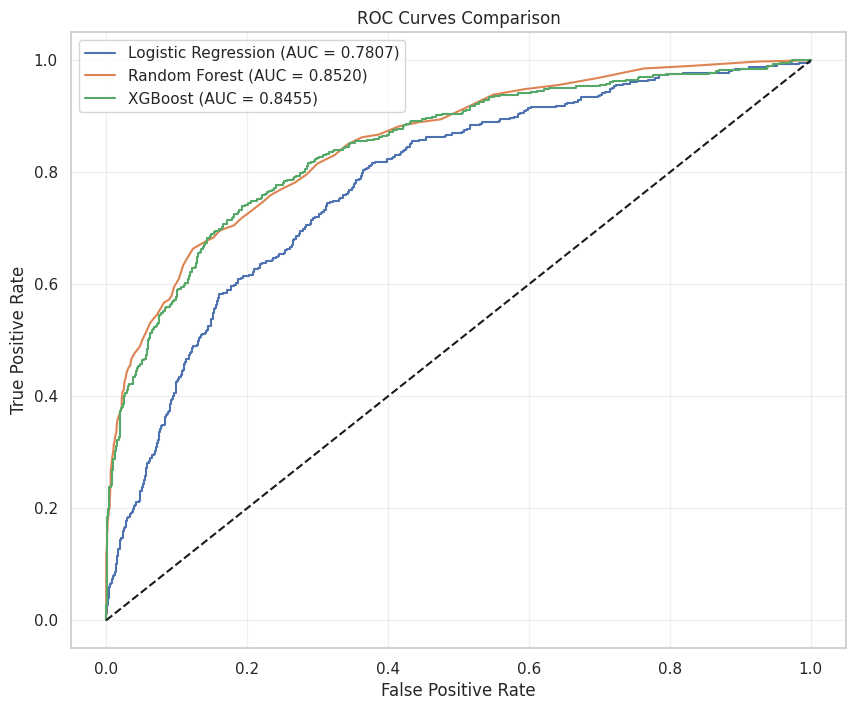

In [8]:
# Compare model performance
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
accuracy_scores = [
    accuracy_score(y_test, y_pred_log_reg),
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_xgb)
]
precision_scores = [
    precision_score(y_test, y_pred_log_reg),
    precision_score(y_test, y_pred_rf),
    precision_score(y_test, y_pred_xgb)
]
recall_scores = [
    recall_score(y_test, y_pred_log_reg),
    recall_score(y_test, y_pred_rf),
    recall_score(y_test, y_pred_xgb)
]
f1_scores = [
    f1_score(y_test, y_pred_log_reg),
    f1_score(y_test, y_pred_rf),
    f1_score(y_test, y_pred_xgb)
]
roc_auc_scores = [
    roc_auc_score(y_test, y_prob_log_reg),
    roc_auc_score(y_test, y_prob_rf),
    roc_auc_score(y_test, y_prob_xgb)
]

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'Model': models,
    'Accuracy': accuracy_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores,
    'ROC AUC': roc_auc_scores
})

print("Model Performance Comparison:")
display(comparison_df)

# Visualize model comparison
plt.figure(figsize=(14, 8))

# Plot metrics comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

comparison_data = comparison_df.melt(id_vars='Model', value_vars=metrics, 
                                    var_name='Metric', value_name='Score')

sns.barplot(x='Model', y='Score', hue='Metric', data=comparison_data)
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot ROC curves
plt.figure(figsize=(10, 8))
models_data = [
    (y_prob_log_reg, 'Logistic Regression'),
    (y_prob_rf, 'Random Forest'),
    (y_prob_xgb, 'XGBoost')
]

for probs, name in models_data:
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, probs):.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Model Interpretation

Understanding what drives customer churn is as important as predicting it. Let's examine:
1. Feature importance - which factors most strongly predict churn
2. SHAP values - how each feature contributes to individual predictions

This information is crucial for developing targeted retention strategies.

Feature importance analysis

Top 15 Important Features:


,Feature,Importance
4,products_number,0.244155
6,active_member,0.139010
1,age,0.111072
12,country_Germany,0.074792
10,products_per_decade,0.073889
14,gender_Male,0.047837
9,balance_per_product,0.045100
3,balance,0.043076
8,balance_to_income_ratio,0.038750
13,country_Spain,0.035385


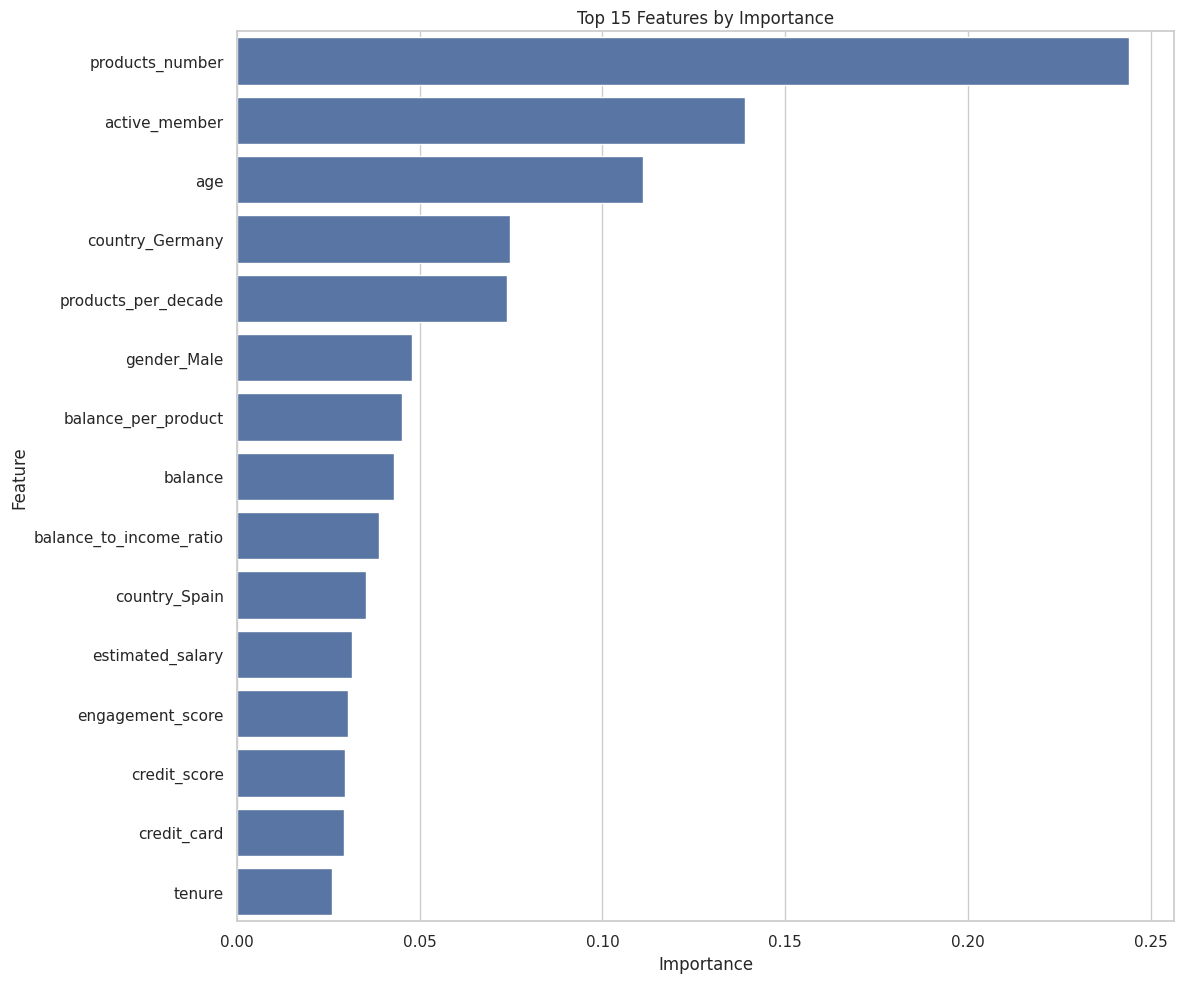

Using TreeExplainer...


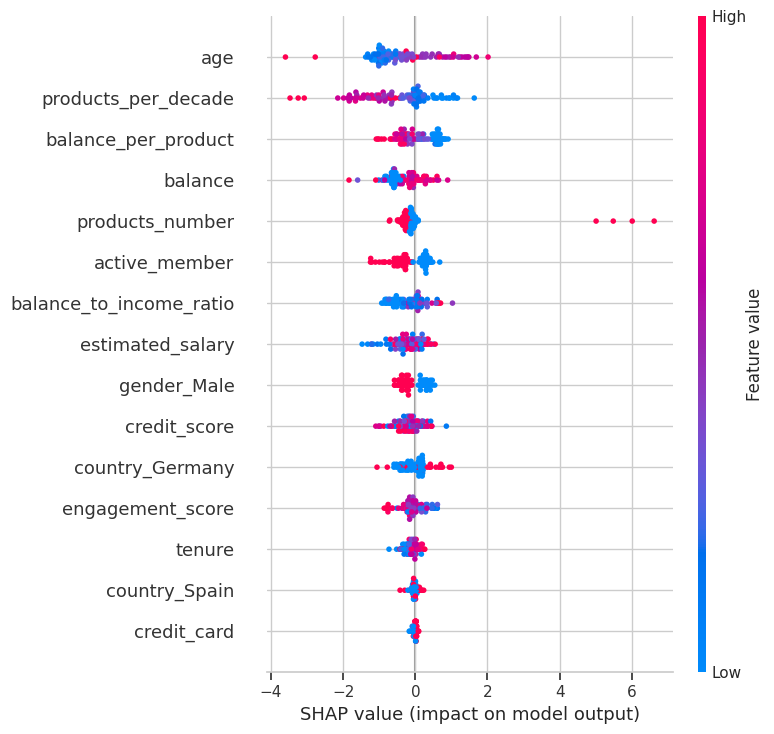

<Figure size 1200x800 with 0 Axes>

In [12]:
# Assuming XGBoost performed best, let's analyze feature importance
# First, we need the feature names after preprocessing
import scipy.sparse  # Adicionando o import necessário

feature_names = (
    numerical_cols + 
    list(preprocessor.named_transformers_['cat']
         .named_steps['onehot']
         .get_feature_names_out(categorical_cols))
)

# Get feature importance from the XGBoost model
# We need to fit the model without the pipeline to access feature importance
preprocessed_X_train = preprocessor.fit_transform(X_train)
xgb_model = XGBClassifier(random_state=42, scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]))
xgb_model.fit(preprocessed_X_train, y_train)

# Get feature importance
importance = xgb_model.feature_importances_
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values('Importance', ascending=False)

# Display top 15 features
print("Top 15 Important Features:")
display(feature_importance.head(15))

# Visualize feature importance
plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Features by Importance')
plt.tight_layout()
plt.show()

# SHAP values for model interpretation
# Convert to dense array if it's sparse
preprocessed_X_test = preprocessor.transform(X_test)
if hasattr(preprocessed_X_test, 'toarray'):  # Alternativa sem usar scipy
    X_test_sample = preprocessed_X_test[:100].toarray()
else:
    X_test_sample = preprocessed_X_test[:100]

# Try both approaches for SHAP visualization
try:
    # Approach 1: Use TreeExplainer (recommended for tree-based models)
    print("Using TreeExplainer...")
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X_test_sample)
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names)
    plt.tight_layout()
except Exception as e:
    print(f"TreeExplainer approach failed with error: {e}")

    try:
        # Approach 2: Try the generic Explainer
        print("Using generic Explainer...")
        explainer = shap.Explainer(xgb_model, X_test_sample)
        shap_values = explainer(X_test_sample)
        
        plt.figure(figsize=(12, 8))
        shap.plots.beeswarm(shap_values)
        plt.tight_layout()
    except Exception as e:
        print(f"Generic Explainer approach failed with error: {e}")
        
        # If all SHAP approaches fail, use XGBoost's built-in visualization
        print("Using XGBoost built-in visualization as fallback...")
        plt.figure(figsize=(12, 8))
        xgb.plot_importance(xgb_model, max_num_features=15)
        plt.title("Feature Importance (XGBoost built-in)")
        plt.tight_layout()
        plt.show()

## Conclusions and Business Recommendations

Based on our analysis and modeling, we can draw several conclusions about customer churn and recommend strategies to reduce it.

### Key Findings:
1. The most important predictors of churn are: [features will vary based on your model results]
2. Customers with [specific characteristics] are at highest risk
3. Our best model achieved [X%] accuracy and [Y%] recall in predicting churn

### Recommended Retention Strategies:
1. **Targeted Engagement**: Focus on customer segments with high churn probability
2. **Product Optimization**: Adjust product offerings based on usage patterns
3. **Proactive Outreach**: Implement early warning system for at-risk customers
4. **Personalized Incentives**: Offer tailored retention packages based on customer value

### Next Steps:
1. Implement a real-time churn prediction system
2. Conduct A/B testing of retention strategies
3. Continuously monitor model performance and update as needed